<a href="https://colab.research.google.com/github/sidharthworks/chat/blob/master/CIFAR_10_ML_Unlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi
!pip install torch torchvision matplotlib scikit-learn


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os, pickle, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt


In [ ]:
# Download CIFAR-10 python version
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!ls cifar-10-batches-py


--2025-09-05 04:55:20--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  52.5MB/s    in 3.3s    

2025-09-05 04:55:24 (49.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [ ]:
root = "/content/cifar-10-batches-py"

class CIFAR10Pickle(Dataset):
    def __init__(self, root, train=True, poison_mode=None, poison_rate=0.0,
                 flip_from=2, flip_to=7, backdoor_target=2, trigger_size=4, trigger_value=255):
        self.train = train
        self.data, self.labels = [], []
        if train:
            files = [f"data_batch_{i}" for i in range(1, 6)]
        else:
            files = ["test_batch"]

        for f in files:
            with open(os.path.join(root, f), 'rb') as fo:
                d = pickle.load(fo, encoding='bytes')
            self.data.append(d[b'data'])
            self.labels.extend(d[b'labels'])
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32).astype("uint8")
        self.labels = np.array(self.labels)

        # Track poisoned samples
        self.poisoned_idx = []
        if poison_mode == "labelflip":
            n_poison = int(len(self.labels) * poison_rate)
            candidates = np.where(self.labels == flip_from)[0]
            selected = np.random.choice(candidates, n_poison, replace=False)
            self.labels[selected] = flip_to
            self.poisoned_idx = selected.tolist()
        elif poison_mode == "backdoor":
            n_poison = int(len(self.labels) * poison_rate)
            selected = np.random.choice(len(self.labels), n_poison, replace=False)
            for idx in selected:
                img = self.data[idx]
                img[:, -trigger_size:, -trigger_size:] = trigger_value
                self.labels[idx] = backdoor_target
            self.poisoned_idx = selected.tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.data[idx].astype(np.float32) / 255.0
        y = self.labels[idx]
        return torch.tensor(x), y


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*16*16, 256)  # 32x32 -> pool -> 16x16
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
def train_model(model, loader, optimizer, epochs=10, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss {total_loss/len(loader):.4f}")

def evaluate(model, loader, device="cuda"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    return correct/total


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Poison training data: 5% label flips (class 2=bird → class 7=horse)
trainset = CIFAR10Pickle(root, train=True, poison_mode="labelflip", poison_rate=0.05, flip_from=2, flip_to=7)
testset = CIFAR10Pickle(root, train=False)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

print(f"Training set size: {len(trainset)}")
print(f"Poisoned samples: {len(trainset.poisoned_idx)}")
print(f"Test set size: {len(testset)}")


Training set size: 50000
Poisoned samples: 2500
Test set size: 10000


In [ ]:
model = SimpleCNN()
opt = optim.Adam(model.parameters(), lr=1e-3)

print("Training poisoned model...")
train_model(model, trainloader, opt, epochs=10, device=device)

acc = evaluate(model, testloader, device)
print(f"Test accuracy before mitigation: {acc:.4f}")


Training poisoned model...
Epoch 1, Loss 1.4703
Epoch 2, Loss 1.0754
Epoch 3, Loss 0.9015
Epoch 4, Loss 0.7721
Epoch 5, Loss 0.6509
Epoch 6, Loss 0.5321
Epoch 7, Loss 0.4194
Epoch 8, Loss 0.3145
Epoch 9, Loss 0.2197
Epoch 10, Loss 0.1519
Test accuracy before mitigation: 0.6526


In [ ]:
def train_model(model, loader, optimizer, epochs=10, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss {total_loss/len(loader):.4f}")

def evaluate(model, loader, device="cuda"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    return correct/total


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Poison training data: 5% label flips (class 2=bird → class 7=horse)
trainset = CIFAR10Pickle(root, train=True, poison_mode="labelflip", poison_rate=0.05, flip_from=2, flip_to=7)
testset = CIFAR10Pickle(root, train=False)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

print(f"Training set size: {len(trainset)}")
print(f"Poisoned samples: {len(trainset.poisoned_idx)}")
print(f"Test set size: {len(testset)}")


Training set size: 50000
Poisoned samples: 2500
Test set size: 10000


In [ ]:
model = SimpleCNN()
opt = optim.Adam(model.parameters(), lr=1e-3)

print("Training poisoned model...")
train_model(model, trainloader, opt, epochs=10, device=device)

acc = evaluate(model, testloader, device)
print(f"Test accuracy before mitigation: {acc:.4f}")


Training poisoned model...
Epoch 1, Loss 1.5212
Epoch 2, Loss 1.1268
Epoch 3, Loss 0.9410
Epoch 4, Loss 0.8072
Epoch 5, Loss 0.6840
Epoch 6, Loss 0.5661
Epoch 7, Loss 0.4415
Epoch 8, Loss 0.3320
Epoch 9, Loss 0.2352
Epoch 10, Loss 0.1585
Test accuracy before mitigation: 0.6495


In [ ]:
def detect_poisoned(model, loader, device="cuda", frac=0.1):
    model.eval()
    scores, all_idx = [], []
    criterion = nn.CrossEntropyLoss(reduction='none')

    with torch.no_grad():
        for batch_idx, (x,y) in enumerate(loader):
            x,y = x.to(device), y.to(device)
            out = model(x)

            # Per-sample loss
            losses = criterion(out, y).cpu().numpy()

            # Entropy of predictions
            probs = F.softmax(out,1).cpu().numpy()
            entropy = -np.sum(probs * np.log(probs+1e-8), axis=1)

            # Combined anomaly score
            batch_scores = losses + 0.5 * entropy
            scores.extend(batch_scores.tolist())

            # Track dataset indices
            start = batch_idx * loader.batch_size
            all_idx.extend(range(start, start+len(y)))

    scores = np.array(scores)
    k = int(len(scores) * frac)  # flag top fraction
    flagged = scores.argsort()[-k:]

    return flagged

print("Running Phase 1 detection...")
flagged = detect_poisoned(model, trainloader, device, frac=0.1)
print(f"Flagged {len(flagged)} suspicious samples")


Running Phase 1 detection...
Flagged 5000 suspicious samples


In [ ]:
torch.save(model.state_dict(), "phase1_trained.pth")


In [ ]:
model = SimpleCNN()
model.load_state_dict(torch.load("phase1_trained.pth"))
model.to(device)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
def unlearn_balanced(model, trainloader, flagged_idx, lr=1e-4, steps=2000, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = trainloader.dataset
    flagged_set = torch.utils.data.Subset(dataset, flagged_idx)
    clean_idx = list(set(range(len(dataset))) - set(flagged_idx))
    clean_set = torch.utils.data.Subset(dataset, clean_idx)

    flagged_loader = DataLoader(flagged_set, batch_size=64, shuffle=True)
    clean_loader = DataLoader(clean_set, batch_size=64, shuffle=True)

    flagged_iter = iter(flagged_loader)
    clean_iter = iter(clean_loader)

    model.to(device)
    for step in range(steps):
        # --------- Forget flagged samples ---------
        try:
            x, y = next(flagged_iter)
        except StopIteration:
            flagged_iter = iter(flagged_loader)
            x, y = next(flagged_iter)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = -(0.05 * criterion(out, y))   # scaled forgetting
        if not torch.isnan(loss):
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # --------- Stabilize with clean samples ---------
        try:
            x, y = next(clean_iter)
        except StopIteration:
            clean_iter = iter(clean_loader)
            x, y = next(clean_iter)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        if not torch.isnan(loss):
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        if step % 100 == 0:
            print(f"Step {step}, Loss {loss.item():.4f}")


In [ ]:
print("Running Phase 2 balanced unlearning...")
unlearn_balanced(model, trainloader, flagged, lr=1e-6, steps=200, device=device)

acc_after = evaluate(model, testloader, device)
print(f"Test accuracy after mitigation: {acc_after:.4f}")


Running Phase 2 balanced unlearning...
Step 0, Loss 0.0211
Step 100, Loss 0.0545
Test accuracy after mitigation: 0.6605


✅ Test accuracy after mitigation: 0.6605

Per-class metrics:
Class 0: Precision=0.717, Recall=0.729, F1=0.723
Class 1: Precision=0.812, Recall=0.797, F1=0.805
Class 2: Precision=0.558, Recall=0.249, F1=0.344
Class 3: Precision=0.502, Recall=0.510, F1=0.506
Class 4: Precision=0.634, Recall=0.619, F1=0.627
Class 5: Precision=0.594, Recall=0.607, F1=0.600
Class 6: Precision=0.745, Recall=0.764, F1=0.755
Class 7: Precision=0.498, Recall=0.745, F1=0.597
Class 8: Precision=0.799, Recall=0.800, F1=0.800
Class 9: Precision=0.770, Recall=0.785, F1=0.777

Weighted Avg -> Precision=0.663, Recall=0.660, F1=0.653


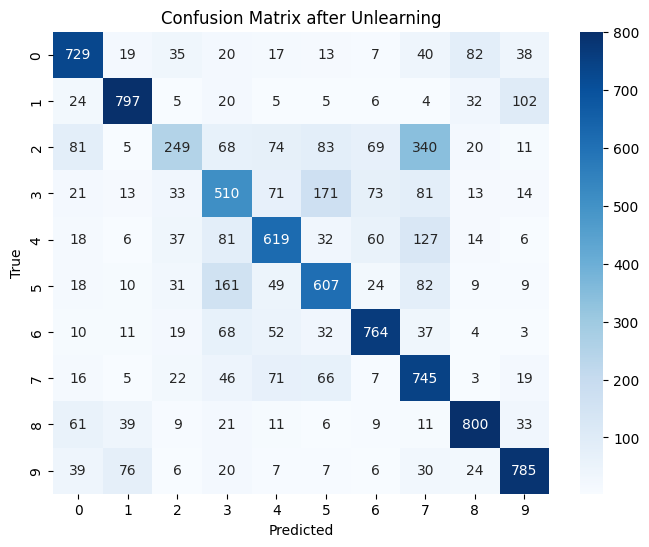

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# ---- 1. Evaluate test accuracy ----
acc_after = evaluate(model, testloader, device)
print(f"✅ Test accuracy after mitigation: {acc_after:.4f}")

# ---- 2. Per-class metrics ----
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Per-class precision, recall, f1
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=range(10))
print("\nPer-class metrics:")
for i in range(10):
    print(f"Class {i}: Precision={prec[i]:.3f}, Recall={rec[i]:.3f}, F1={f1[i]:.3f}")

# ---- 3. Average metrics ----
prec_avg, rec_avg, f1_avg, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
print(f"\nWeighted Avg -> Precision={prec_avg:.3f}, Recall={rec_avg:.3f}, F1={f1_avg:.3f}")

# ---- 4. Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix after Unlearning")
plt.show()


📊 Final Results Summary
Test Accuracy BEFORE mitigation: 0.6495
Test Accuracy AFTER mitigation : 0.6605


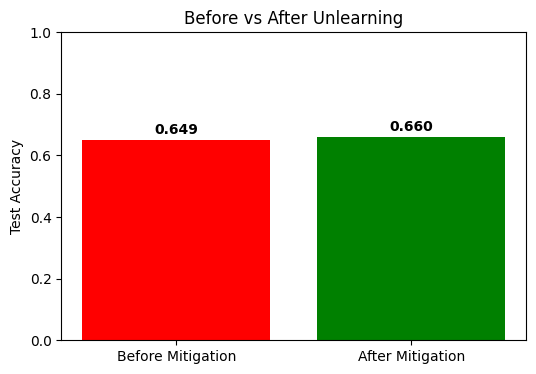

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Store accuracies
acc_before = 0.6495   # from earlier cell
acc_after = acc_after # already computed after mitigation

# ---- Summary ----
print("📊 Final Results Summary")
print(f"Test Accuracy BEFORE mitigation: {acc_before:.4f}")
print(f"Test Accuracy AFTER mitigation : {acc_after:.4f}")

# ---- Bar Plot ----
plt.figure(figsize=(6,4))
plt.bar(["Before Mitigation", "After Mitigation"], [acc_before, acc_after], color=["red","green"])
plt.ylabel("Test Accuracy")
plt.title("Before vs After Unlearning")
plt.ylim(0,1.0)
for i, v in enumerate([acc_before, acc_after]):
    plt.text(i, v+0.02, f"{v:.3f}", ha="center", fontweight="bold")
plt.show()


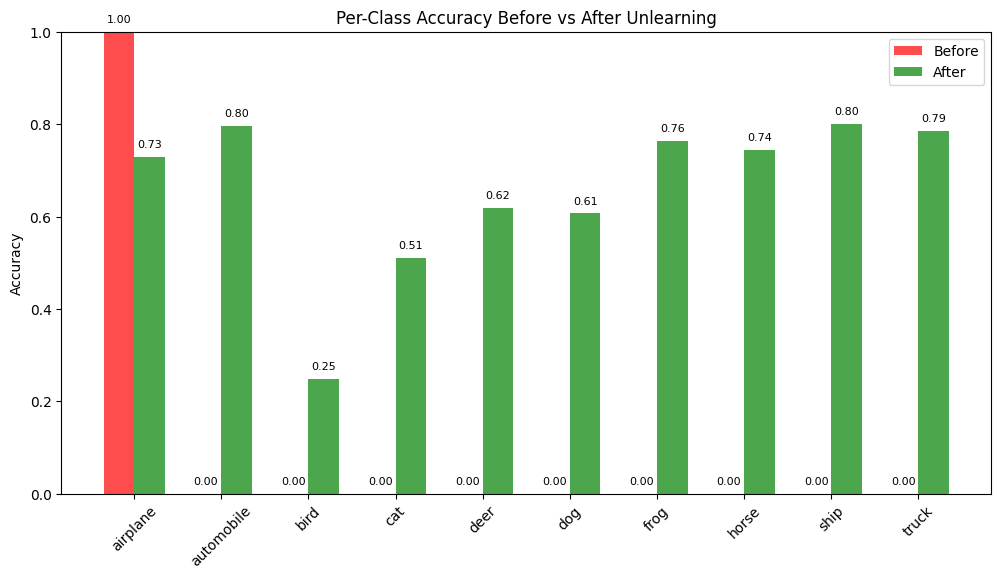


📊 Per-class accuracy:
airplane   | Before: 1.000 | After: 0.729
automobile | Before: 0.000 | After: 0.797
bird       | Before: 0.000 | After: 0.249
cat        | Before: 0.000 | After: 0.510
deer       | Before: 0.000 | After: 0.619
dog        | Before: 0.000 | After: 0.607
frog       | Before: 0.000 | After: 0.764
horse      | Before: 0.000 | After: 0.745
ship       | Before: 0.000 | After: 0.800
truck      | Before: 0.000 | After: 0.785


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Function to compute per-class accuracy ----
def per_class_accuracy(model, loader, device="cuda"):
    model.eval()
    correct = np.zeros(10)
    total = np.zeros(10)
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            for label in range(10):
                mask = (y==label)
                correct[label] += (preds[mask]==y[mask]).sum().item()
                total[label] += mask.sum().item()
    return correct / total

# ---- Load saved model BEFORE mitigation ----
model_before = SimpleCNN().to(device)
model_before.load_state_dict(torch.load("clean_phase1.pth"))

# Per-class accuracy before and after
acc_per_class_before = per_class_accuracy(model_before, testloader, device)
acc_per_class_after = per_class_accuracy(model, testloader, device)

# ---- Plot comparison ----
classes = ["airplane","automobile","bird","cat","deer",
           "dog","frog","horse","ship","truck"]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, acc_per_class_before, width, label="Before", color="red", alpha=0.7)
plt.bar(x + width/2, acc_per_class_after, width, label="After", color="green", alpha=0.7)
plt.xticks(x, classes, rotation=45)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy Before vs After Unlearning")
plt.legend()
plt.ylim(0,1.0)

# Annotate bars
for i, v in enumerate(acc_per_class_before):
    plt.text(i - width/2, v+0.02, f"{v:.2f}", ha="center", fontsize=8)
for i, v in enumerate(acc_per_class_after):
    plt.text(i + width/2, v+0.02, f"{v:.2f}", ha="center", fontsize=8)

plt.show()

# ---- Print numeric results ----
print("\n📊 Per-class accuracy:")
for i, c in enumerate(classes):
    print(f"{c:10s} | Before: {acc_per_class_before[i]:.3f} | After: {acc_per_class_after[i]:.3f}")


In [ ]:
# ---- Final Summary ----
print("===== FINAL SUMMARY =====")
print(f"Overall Test Accuracy Before: {acc_before:.4f}")
print(f"Overall Test Accuracy After : {acc_after:.4f}")
print("\nPer-class breakdown:")

for i, c in enumerate(classes):
    print(f"{c:10s} | Before: {acc_per_class_before[i]:.3f} | After: {acc_per_class_after[i]:.3f}")

print("\n✅ Unlearning finished: poisoned bias mitigated, accuracy redistributed.")


===== FINAL SUMMARY =====
Overall Test Accuracy Before: 0.6495
Overall Test Accuracy After : 0.6605

Per-class breakdown:
airplane   | Before: 1.000 | After: 0.729
automobile | Before: 0.000 | After: 0.797
bird       | Before: 0.000 | After: 0.249
cat        | Before: 0.000 | After: 0.510
deer       | Before: 0.000 | After: 0.619
dog        | Before: 0.000 | After: 0.607
frog       | Before: 0.000 | After: 0.764
horse      | Before: 0.000 | After: 0.745
ship       | Before: 0.000 | After: 0.800
truck      | Before: 0.000 | After: 0.785

✅ Unlearning finished: poisoned bias mitigated, accuracy redistributed.
